This lab activity is intended to teach students the mechanics of the Hartree-Fock procedure, without getting into the details of calculating the 1 and 2 electron integrals, by using the machinary of the Psi4 quantum chemistry software package.

Prerequisite knowledge:  This lab assumes that the students understand the principles, though not the mathematics, of constructing the Fock matrix and that diagaonlizing the Fock matrix leads to the molecular orbital energies and coefficients.  The lab also assumes all the [standard python pre-requisites of all Psi4Education labs](https://admiring-tesla-08529a.netlify.com/posts/psi4jupyter_labs/).  

Learning ojbectives:
1. Recognize that the AO basis is not orthonormal and must be transformed.
2. Transform a from one basis to another using a transformation matrix.
3. Recognize the interative nature of the HF procedure and what leds to the need for the iterative process.  
4. Define convergence and use convergence criteria in a self-consistent procedure. 
5. Calculate MO energies and coefficients by diagonalizing the Fock matrix.  

Based on:
Authors: Ashley Ringer McDonald (armcdona@calpoly.edu; [ORCID: 0000-0002-4381-1239](https://orcid.org/0000-0002-4381-1239)) and Dominic A. Sirianni (sirianni.dom@gmail.com; [ORCID: 0000-0002-6464-0213](https://orcid.org/0000-0002-6464-0213) )
Modified by Sean Garrett-Roe (sgr@pitt.edu) and Tricia Shepherd (profshep@icloud.com)

Copyright: Psi4Education Project, 2019


# Introduction: Hartree-Fock Procedure for Approximate Quantum Chemistry

In [12]:
# ==> Import Psi4 & NumPy <==
import psi4
import numpy as np
import scipy as sp

## Warm up with the H atom
By solving the Hydrogen atom Schrödinger equation, we saw that the expression for the different
energy levels is given by:

$$E_{n} = -\frac{m_e e^4}{8\epsilon_0^2h^2n^2}=-\frac{m_ee^4}{2(4\pi\epsilon_0)^2\hbar^2n^2}\qquad(1)$$

Atomic units (a.u.) are based on fundamental quantities so that many physical constants have numerical values of 1: 

| Symbol | Quantity | Value in a.u. | Value in SI units
|---|---|---|---|
| $e$ | electron charge| 1 |$1.602\times 10^{-19}$ C |
| $m_e$ | electron mass| 1 |$9.110\times 10^{-31}$ kg |
| $\hbar$ | angular momentum| 1 |$1.055\times 10^{-34}$ J s |
| $a_0$ | Bohr radius (atomic distance unit)| 1 |$5.292\times 10^{-11}$ m |
| $E$ | Hartree energy (atomic energy unit)| 1 |$4.360\times 10^{-18}$ J |
| $4\pi\epsilon_0$ | vacuum permittivity| 1 |$1.113\times 10^{-10}$ C$^2$/J m |. 

#### 1) Verify that the two forms of Eq. (1) agree.


#### 2) Rewrite $E_n$ in atomic units.
Use the values for the physical constants $e$, $m_e$, $\hbar$, and $4\pi\epsilon_0$ in the table above. (edit formula below)
$$E_n = \frac{}{}\qquad(a.u.)$$ 

By looking up the values of these constants, we can also compute the ground state energy of the Hydrogen atom
numerically. In the cell below, compute the exact H atom ground state energy in SI units and explicitly convert from SI to hartrees:

In [13]:
# ==> Toy Example: The Hydrogen Atom <==
# Define fundamental constants in SI units
m_e = 9.1093837015e-31 # kg
e = 1.602176634e-19 # C
epsilon_0 = 8.8541878128e-12 # F / m
h = 6.62607015e-34 # J*s
n = 1

# Define a.u. to SI energy conversion factor (https://en.wikipedia.org/wiki/Hartree)
hartree2joules = 4.359744650e-18

# Compute ground state energy of H atom in SI units using constants above
E_1 = -(m_e * e**4) / (8 * epsilon_0**2 * h**2 * n**2)

# Convert to atomic units
E_1_au = E_1 / hartree2joules

print(f'The exact ground state energy of the H atom in SI units is: {E_1} J')
print(f'The exact ground state energy of the H atom in atomic units is: {E_1_au} Eh')

The exact ground state energy of the H atom in SI units is: -2.1798723610862185e-18 J
The exact ground state energy of the H atom in atomic units is: -0.5000000082771404 Eh


#### 3) Numerically find the H atom energy with Psi4.

We obtained the Hydrogen atom energy expression above by solving the Schrödinger equation exactly.
But what happens if we cannot do this?

That's where Hartree-Fock molecular orbital theory comes in! Just as a test case, let's use Psi4 to compute the
Hartree-Fock wavefunction and energy for the Hydrogen atom:

In [14]:
# ==> Compute H atom energy with Hartree-Fock using Psi4 <==

# the H atom has a charge of 0, spin multiplicity of 2 (m_s=1/2), and we place it at the xyz origin (0,0,0)
h_atom = psi4.geometry("""
0 2
H 0 0 0
""")

psi4.set_options({'reference': 'rohf',
                  'scf_type': 'pk'
                 })

e = psi4.energy('scf/d-aug-cc-pv5z')
psi4.core.clean()

print(f"The Hartree-Fock ground state energy of the H atom in SI units is: {e * psi4.constants.hartree2J} J")
print(f"The Hartree-Fock ground state energy of the H atom in atomic units is: {e} Eh")

The Hartree-Fock ground state energy of the H atom in SI units is: -2.1798496583620466e-18 J
The Hartree-Fock ground state energy of the H atom in atomic units is: -0.4999948009253356 Eh


## The Hartree-Fock procedure
In this lab activity, you will be building and diagonalizing the Fock matrix to determine the MO coefficients and energies for a molecule.  We will be using the functions of the Psi4 quantum chemistry software package to compute the integrals we need.  The following notebook will lead you through setting up your molecule, establishing the basis set, and forming and diagonalizing the Fock matrix.  Be sure to run each cell as your proceed through the notebook.

### Specifying the molecule

H$_2$O is a small but interesting molecule to use in our exploration. 

#### 4) Based on your chemical intuition, answer the following questions for the H$_2$O molecule:
##### How many electrons are there in total?
##### How many electrons are paired and how many are unpaired?
##### How many occupied molecular orbitals would you expect?

Before we can begin to implement the HF procedure, we need to specifcy the molecule and basis set that we will be using.  We will also set the memory usage for our calcluation and the output file name.  

In [113]:
# ==> Set Basic Psi4 Options <==
# Memory specification
psi4.set_memory('500 MB')
numpy_memory = 2 # No NumPy array can exceed 2 MB in size

# Set output file
psi4.core.set_output_file('output.dat', False)

# Specify the basis
basis = 'cc-pvdz'
#basis = 'sto-3g'


# Set computation options
psi4.set_options({'basis': basis,
                  'scf_type': 'pk',
                  'e_convergence': 1e-8})


# ==> Define Molecule <==
# Define our model of water -- we will distort the molecule later, which may require C1 symmetry
mol = psi4.geometry("""
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""")

Next, we need to build the wavefunction from the basis functions.  We store the wavefunction in a variable called `wfn`. We use the function `nalpha()` provided by the wavefunction object we created above, `wfn`, to determine the number of orbitals with spin alpha, which will be doubly occupied orbitals for close shelled systems. We save this answer as a variable called `ndocc` (number of doubly occupied orbitals).  

#### Confirm that the number of doubly occupied orbitals matches your expectation for the molecule you chose.

In [114]:
# ==> Compute static 1e- and 2e- quantities with Psi4 <==
wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))

#number of spin alpha orbitals (doubly occupied for closed-shell systems)
ndocc = wfn.nalpha()
nbf = wfn.basisset().nbf()

print(F'Number of occupied orbitals: {ndocc}')
print(F'Number of basis functions: {nbf}') 

Number of occupied orbitals: 5
Number of basis functions: 24


### Orthogonalizing the AO basis set

Crash course in Dirac notation:

The wavefunction, $\psi(x)$ can be represented as a *column vector*, $|\psi\rangle$ . The complex conjugate of the wavefunction, $\psi^*(x)$ is also represented by a vector which is the complex conjugate transpose of $|\psi\rangle$. 

\begin{align}
\psi(x)&\rightarrow|\psi\rangle\quad\text{column vector}\\
\psi^*(x)&\rightarrow\langle\psi|\quad\text{row vector}
\end{align}

The normalization of a wavefunction $\psi(x)$ is an integral

$$\int\psi^*(x)\psi(x)\;\mathrm{d}x=1.$$

In Dirac notation, it is replaced with a vector equation

$$\langle\psi|\psi\rangle=1.$$

The orthogonality of two wavefunctions, $\psi_i(x)$ and $\psi_j(x)$, which, in integral notation, is

$$\int\psi_i^*(x)\psi_j(x)\;\mathrm{d}x=0,$$

becomes, in Dirac notation,

$$\langle\psi_i|\psi_j\rangle=1.$$
 
#### Define two vectors, `phi1` and `phi2`, with two elements each, that are normalized (in the sense $\langle\phi_i|\phi_i\rangle=1$) and orthogonal in sense that $\langle\phi_i|\phi_j\rangle=0$.

In [ ]:
#define a first basis vector and a second, orthogonal vector
phi1 = np.array([1,0])
phi2 = np.array([0,1])

#phi1 = 1/np.sqrt(2)*np.array([1,1])
#phi2 = 1/np.sqrt(2)*np.array([1,-1])

#or
#phi1 = np.array([1j,0])
#phi2 = np.array([0,1])

#or not orthogonal
#phi1 = np.array([1j,0.1])
#phi2 = np.array([0,1])

print(F'Phi1: {phi1}')
print(F'Phi2: {phi2}')
print()#empty line

Numpy commands for these vector operations:
```
v.dot(v)
v.conj()
v.conj().dot(v)
```

#### Show that `phi1` and `phi2` are orthonormal.

In [ ]:
#calculate normalization

Print{F'<phi1|phi1> = {}'}

Print{F'<phi2|phi2> = {}'}

# calculate orthogonality

Print{F'<phi1|phi2> = {}'}

Print{F'<phi1|phi2> = {}'}



Recall that if we had used the hydrogen atom wavefunctions as our basis set, the AO wavefunctions would all be orthonormal.  Since we used a basis set of Gaussian wavefuctions, however, this may not be the case. We will now introduce some tools to detect this problem and to fix it!

**Overlap integrals are matrix elements** For a set of basis functions, $\phi_i(\tau)$, where $\tau$ is a shorthand for all the coordinates of all the particles, we can calculate the overlap integrals between the basis functions in the following way

$$S_{ij}=\int {\rm d}\tau\; \phi_i^*(\tau)\phi_j(\tau).$$

#### Define $S_{ij}$ using Dirac notation.

#### Calculate the terms `S_ij` using the basis vectors `phi1` and `phi2`. 

In [131]:
#calculate the overlap (inner product) of the vectors 
S_11 = phi1.conj().dot(phi1)
S_12 = phi1.conj().dot(phi2) ###remove r.h.s. from student code
S_21 = phi2.conj().dot(phi1) #"
S_22 = phi2.conj().dot(phi2) #"
print('The ij elements of S:')
print(S_11,S_12)
print(S_21,S_22)
print()


The ij elements of S:
1 0
0 1



**The overlap matrix** 
These overlap integrals, $S_{ij}$, can be interpreted as the elements on the $i$-th row and $j$-th column of a matrix, $S$. Let's propose a matrix, $S$, made of the overlap integrals $S_{ij}$. We can build $S$ systematically in the following way. First, make a matrix, $B$, composed of our basis vectors as columns,

$$ B = \left(\begin{array}{ccc}|& |&|\\ \phi_1 &\phi_2&\phi_3\\|&|&|\end{array}\right).$$

We will use the symbol $\dagger$ to indicate the complex conjugate of the transpose of a matrix. So

$$B^\dagger = (B^T)^*.$$

In [133]:
#construct the overlap matrix from matrix of basis vectors
vector_length = phi1.size #length of the vector space
phi1_column = phi1.reshape(vector_length,1) #this makes phi a column vector
phi2_column = phi2.reshape(vector_length,1)

# put together (concatenate) the vectors into the matrix B
B = np.concatenate((phi1_column,phi2_column),axis=1)
print(F'The matrix B:\n{B}')

B_dagger = B.conj().T
print(F'The matrix B^\dagger:\n{B_dagger}')

The matrix B:
[[1 0]
 [0 1]]
The matrix B^\dagger:
[[1 0]
 [0 1]]


Now, multiplying the rows of $B^\dagger$ by the columns of $B$ (normal matrix multiplication) produces a matrix of the overlap integrals in the correct locations. we defined to be the matrix $S$.

$$B^\dagger B =\left(\begin{array}{ccc}-& \phi_1^*&-\\-& \phi_2^* &-\\-&\phi_3&-\end{array}\right) \left(\begin{array}{ccc}|& |&|\\ \phi_1 &\phi_2&\phi_3\\|&|&|\end{array}\right)\equiv S.$$

#### Use `B` and `B_dagger` to calculate the matrix `S`.

In [136]:
#calculate S from matrix of basis vectors
S = B.conj().T.dot(B) #read left to right: ((B complex conj) transpose) times B
print(F'The matrix of eigenvectors in columns B =\n {B} \n\nand S = B^\dagger B =\n{S}\n')

The matrix of eigenvectors in columns B =
 [[1 0]
 [0 1]] 

and S = B^\dagger B =
[[1 0]
 [0 1]]



**Einstein implicit summation notation** Matrix multiplication is defined through

$$(AB)_{pq}= \sum_i A_{p,i}B_{i,q}\qquad\text{explicit summation}$$

Note that there is a repeated index, $i$, in the summation. In implicit summation notation, Einstein notation, we do not write the $\sum$ and treat the summation as understood. 

$$(AB)_{pq}=A_{p,i}B_{i,q}\qquad\text{implicit summation}$$

Using implicit summation for the case at hand, $B^\dagger B$ gives

$$S_{pq}=(B^\dagger B)_{pq}= (B^\dagger)_{p,i}B_{i,q}\qquad\text{implicit summation}$$
$$= (B^*)_{i,p}B_{i,q}\qquad\text{implicit summation}$$

where $B^*$ is the complex conjugate of $B$ (no transpose). Note that the two sets of indices, $(i,p)$ and $(i,q)$, in the input matrices become one set, $(p,q)$, in the product. There is a convenient function in `numpy` that uses this notation `numpy.einsum('ip,iq->pq',B.conj(),B)`, as demonstrated below. 

Let's try this with a simple basis set of two (perhaps) orthonormal vectors.

#### Use the function `numpy.einsum()` to calculate the matrix `S`, and confirm that your answer is the same as above.

In [135]:
#calculate S from Einstein sum
S = np.einsum('ip,iq->pq',B.conj(),B)
print(F'S from Einstein notation:\n{S}')

S from Einstein notation:
[[1 0]
 [0 1]]


#### Question:  For an orthonormal basis, what does the overlap integral array, `S`, look like?

**Answer:** It would be 1's along the diagonal and 0's for all other matrix elements, i.e. an identity matrix.

#### Propose a different orthonormal basis, modify `phi1` and `phi2`, and verify that `S` still has the same form. There are infinitely many choices. It isn't complex... or *is* it?!

**Answer:**  The choice $1/\sqrt{2}(1, 1)$ and $1/\sqrt{2}(1, -1)$ are easy to motivate. The pair $(1i,0)$ and $(0,1)$ is an obvious choice for complex vectors.

#### Propose what will happen to `S` if the vectors are not orthonormal. Test your prediction!

### Gaussian atomic orbital basis set
Next we will examine the atomic orbital basis set. To do this, we have to set up a data structure, called a class, to calculate the molecular integrals. (Psi4 will do the nasty calculus for us.) We will call this data structure `mints` (Molecular INTegralS). We use the function `ao_overlap` to calculate the overlap integrals between all the AO basis functions.  We cast this to a numpy array called `S`. 

_(Python programming aside: `asarray()` is a special case of `array()` that does not copy arrays when compatible and converts array subclasses to base class ndarrays. https://stackoverflow.com/questions/14415741/what-is-the-difference-between-numpys-array-and-asarray-functions)_ 

In [116]:
# Construct a molecular integrals object
mints = psi4.core.MintsHelper(wfn.basisset())

# Overlap matrix as a psi4 Matrix object
S_matrix = mints.ao_overlap()

# Overlap matrix converted into an ndarray
S = np.asarray(S_matrix) 

print(F'Shape of S is {S.shape}')

Shape of S is (24, 24)


#### Explain the shape (number of rows and columns) of `S` in terms of the AO basis set we chose.

Examine the contents of `S`.

In [117]:
print(S) #the full matrix is somewhat hard to read

[[ 1.00000000e+00 -2.14062652e-01  1.94384152e-01 -9.09438117e-18
   0.00000000e+00  0.00000000e+00 -2.33216945e-18  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.45999929e-02  6.15289762e-02
  -3.97443884e-02  0.00000000e+00  5.08704974e-02  3.45999929e-02
   6.15289762e-02 -3.97443884e-02  0.00000000e+00 -5.08704974e-02]
 [-2.14062652e-01  1.00000000e+00  7.08607329e-01 -2.42737883e-17
   0.00000000e+00  0.00000000e+00  1.97936403e-18  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.96930552e-01  2.90859084e-01
  -1.91271784e-01  0.00000000e+00  2.44816719e-01  1.96930552e-01
   2.90859084e-01 -1.91271784e-01  0.00000000e+00 -2.44816719e-01]
 [ 1.94384152e-01  7.08607329e-01  1.00000000e+00  3.01517971e-17
   0.00000000e+00  0.00000000e+00  2.90784214e-17  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.000

In [118]:
#Look at the first few elements
def peak(S,nrows=4,ncols=4):
    print(F'Here is a peak at the first {nrows} x {ncols} elements of the matrix:\n{S[:nrows,:ncols]}')
    
peak(S)

Here is a peak at the first 4 x 4 elements of the matrix:
[[ 1.00000000e+00 -2.14062652e-01  1.94384152e-01 -9.09438117e-18]
 [-2.14062652e-01  1.00000000e+00  7.08607329e-01 -2.42737883e-17]
 [ 1.94384152e-01  7.08607329e-01  1.00000000e+00  3.01517971e-17]
 [-9.09438117e-18 -2.42737883e-17  3.01517971e-17  1.00000000e+00]]


#### List your observations about `S` in the AO basis.
#### What do the diagonal elements of `S` indicate?
#### What do the off-diagonal elements of `S` indicate?
#### Does the Gaussian atomic orbital basis set form an orthonormal basis? 

We can perform this test programmatically as well, with a few python tricks. Construct an array of the same size as the overlap array (`S`) that has 1's along the diagonal and 0's everywhere else. Then compare that array to the `S` array to determine if the AO basis is orthonormal.

In [119]:
## example of testing for orthonormality

#define a function
def isBasisOrthonormal(S):
    #get the number of rows of S
    size_S = S.shape[0] 
    
    #construct an identity matrix, I -- "eye", get it?!? Ha ha! Math is so funny!
    identity_matrix = np.eye(size_S) 

    #are all elements of S numerically close to the identity matrix? 
    #We won't test for equality because there can be very small numerical differences that we don't care about
    orthonormal_check = np.allclose(S, identity_matrix)

    print(F'Q:(T/F) The AO basis is orthonormal? A: {orthonormal_check}')
    return orthonormal_check

#use the function
isBasisOrthonormal(S)

Q:(T/F) The AO basis is orthonormal? A: False


False

#### Does the result agree with what you determined above?

### An orthogonalization matrix
Since our AO basis set was not orthonormal, we seek to construct an orthogonalization matrix, $A$, such that ${\bf A}^{\dagger}{\bf SA} = {\bf 1}$. 

**Motivation:** If ${\bf A}$ and ${\bf S}$ were real numbers $a$ and $s$ (not matrices), this would be simple to solve. First, $a^\dagger=a$ because a real number is the same as its hermitian transpose. By simple algebra we can solve for a,

$$a^\dagger s a=1$$
$$a^\dagger s a=a s a=a^2s=1$$
$$\Rightarrow{}a=s^{-1/2}$$ 

In linear algebra (with matrices instead of numbers) this is more complicated, but numpy and the mints class can take care of the details for us! Leaving out the details, we will calculate

$${\bf A}={\bf S}^{-1/2}$$.

#### Use the function `np.linalg.inv()` to calculate the inverse of `S`, and the function `sp.linalg.sqrtm()` to take its (matrix) square root. Execute the code below and examine the matrix `A`

In [123]:
# ==> Construct AO orthogonalization matrix A <==

#inverse of S using np.linalg.inv

#matrix square root of the inverse of S using sp.linalg.sqrtm
A = sp.linalg.sqrtm(np.linalg.inv(S))

peak(A)

Here is a peak at the first 4 x 4 elements of the matrix:
[[ 1.14013138  0.37241884 -0.49486894  0.00665229]
 [ 0.37241884  1.59319502 -1.00179637  0.02740715]
 [-0.49486894 -1.00179637  3.01429626  0.0767127 ]
 [ 0.00665229  0.02740715  0.0767127   1.15450717]]


#### What do you observe about the elements of `A`? Is the matrix real or complex? Is the matrix symmetric or not?

Our basis set $B$ is not orthonormal, so we want to take linear combinations of its columns to make a new basis set, $B'$, that is orthonormal. We define a new matrix, $A$, in terms of that transformation,

$$B' = BA.$$

The new overlap matrix will be

\begin{align}
 S' &= B'^\dagger B',\\
 &= (BA)^\dagger (BA),\\
&= A^\dagger B^\dagger BA,\\
&= A^\dagger S A.
\end{align}
The matrix $A$ makes the proper linear combination of the columns of $B$ and $A^\dagger$ makes the linear combinations of the rows of $B^\dagger$. This is a very common structure of transformation matrices. Because $S$ is real and symmetric, $A$ is also real and symmetric, so $A^\dagger=A$. The transformation becomes simply

$$S' = A S A.$$

#### Use the orthogonalization matrix `A` to transform the overlap matrix, `S`. Check the transformed overlap matrix to make sure it represents an orthonormal basis.

In [23]:

# Here is an example of transforming a matrix through multiplication S' = A S A
S_p = A.dot(S).dot(A) 

isBasisOrthonormal(S_p)


Q:(T/F) The AO basis is orthonormal? A: True


True

#### The product A S A does not take the complex conjugate transpose of A. What conditions (properties of A) make that ok?

## New section not sure yet what to call it

Need to do:
- define H, T, V, F, I and density D
- guiding questions on transforming F
- guiding questions on rotating coefficients back like above (check if order matters -- inverse??)

The Schrödinger equation has the structure of an eigenvalue equation

$$\hat{H}|\psi\rangle = E|\psi\rangle$$

In Hartree-Fock theory, this is reexpresed in terms of the Fock matrix, $F$, a matrix of wavefunction amplitudes for each MO, $C$, and the overlap matrix, $S$,

$$FC = SCE.\qquad(\text{*})$$

When $S$ is not equal to the identity matrix (i.e. the basis is not orthonormal), then this is a pseudo-eigenvalue problem, which is harder to solve. We will solve the problem by transforming the basis set using our orthogonalization matrix $A$. A common linear algebra trick is to "insert one." In this case, the matrix $A$ times its inverse is, by definition the identity matrix, $AA^{-1}={\bf1}$. We can put that factor of one anywhere in an equation that is useful to us, and, then, typically we regroup terms in a way we want. In this case, we insert one  bewteen $FC$ and $SC$.

\begin{align}
FC&=SCE\\
F({\bf1})C&=S({\bf1})CE\\
FAA^{-1}C&=SAA^{-1}CE
\end{align}
Multiplying on the left by $A$ then gives

$$
AFAA^{-1}C=ASAA^{-1}CE
$$

We can recognize the transformation $S'=ASA$ on the right hand side and similarly define $F'=AFA$ on the left hand side. Lastly, we define a transformed coefficient matrix, $C'=A^{-1}C$. Our transformed Fock equation reads

\begin{align}
F'C'&=S'C'E,\\
&=C'E.
\end{align}

The last line follows because $S'={\bf1}$ in our new basis. We now have an eigenvalue problem that we can solve by matrix diagonalization.

#### If $C'=A^{-1}C$, propose a definition of $C$ in terms of $A$ and $C'$. 

## Initial guess for the Fock matrix 
Use the one electron Hamiltonian (goes here) H=T+V->F->diagonlize->energies and coeffs. Then do density matrix. THEEEEEENNNNNNNN introduce J and K etc...

## Add Coulomb and Exchange Integrals to the Fock Matrix

The Fock matrix is 

$$
F = H + 2J - K
$$
where $H$ is the one electron "core" Hamiltonian, $J$ is the Coulomb integral matrix, and $K$ is the exchange integral matrix. The HF energy can be expressed in explicit terms of one and two electron integrals
$$
E_{HF} = \sum_i^{elec}\langle i|h_i|i\rangle + \sum_{i>j}^{elec}[ii|jj]-[ij|ji]
$$
Expanding the orbitals in terms of basis functions, we find
$$
[ii|jj]=\sum_{pqrs}c^*_{pi}c_{qi}c^*_{rj}c_{sj}\int{\rm d}\tau\; \phi_p^*(1)\phi_q(1)\frac{1}{r_{ij}}\phi_r^*(2)\phi_s(2)\qquad{\text{(**)}}
$$
The integral on the right is super important. It has four indicies, $p,q,r,s$, so formally it is a tensor. It accounts for the repulsion between pairs of electrons, so it is called the electron repulsion integral tensor, $I$,
$$
I_{pqrs} = \int{\rm d}\tau\; \phi_p^*(1)\phi_q(1)\frac{1}{r_{ij}}\phi_r^*(2)\phi_s(2).
$$
Now look at the coefficients. They come in two pairs of complex-conjugates, $c^*_{pi}c_{qi}$ and $c^*_{ri}c_{si}$. The diagonal terms, when $p=q$ for example, are the probability of some basis function $p$ contributing to the MO $i$. We will sum each term over the orbitals, $i$, to form the "density matrix"
$$
D_{pq}=\sum_i c^*_{pi}c_{qi}.
$$
Eq. (\*\*) can be expressed in terms of $I$ and $D$ as
\begin{align}
[ii|jj] &= \sum_{pqrs}D_{pq}D_{rs}I_{pqrs},\\
&=\sum_{pq}D_{pq}\sum_{rs}D_{rs}I_{pqrs}.
\end{align}
The term $\sum_{rs}D_{rs}I_{pqrs}$ is the effective repulsion felt by one electron due to the other electrons in the system. This term is the Coulomb integral matrix
$$
J_{pq}=\sum_{rs}D_{rs}I_{pqrs}.
$$

Similarly, 
\begin{align}
[ij|ji] &= \sum_{pqrs}D_{ps}D_{rq}I_{pqrs},\\
 &= \sum_{ps}D_{ps}\sum_{rq}D_{rq}I_{pqrs}.
\end{align}
corrects the repulsion due to electrons "avoiding each other" due to their Fermionic (antisymmetric w.r.t. exchange) character. This term is the exchange integral matrix
$$
K_{ps}=\sum_{rq}D_{rq}I_{pqrs}.
$$



First, we can build the electron-repulsion integral (ERI) tensor, which calculates the electron repulsion between the atomic orbital wavefunctions, and the core Hamiltonian. Mints does all the work for us! Similarly for the one electron Hamiltonian.

In [24]:
# Build electron repulsion integral (ERI) Tensor
I = np.asarray(mints.ao_eri())

# Build core Hamiltonian
T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
H = T + V

Now we would have to recompute the ERI and all the core Hamiltonian matrices in the new orthogonal basis **OR** we can just calculate orbital coefficient matrix in the transformed basis by diagonalizing the transformed Fock matrix, and then just go backwards and get the cofficients in the original AO basis.

We see here the central premise of SCF:  To get the Fock matrix, we need the coefficient matrix, but to compute the coefficient matrix we need the Fock matrix.  So we start with a guess for the Fock matrix, which is the core Hamiltonian matrix that we already calculated.

In the cell below, use the core Hamiltonian matrix as your initial guess for the Fock matrix. Transform it with the same A matrix you used above.  Look up the `linalg.eigh` function in the numpy documentation, and use it to diagonalize the transformed Fock matrix.

In [25]:
# This is the code we would expect the student to write

# Transformed Fock matrix
F_p = A.dot(H).dot(A)

# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
e, C_p = np.linalg.eigh(F_p)

Now that we have the coefficents in the transformed basis, we need to go back and get the coefficients in the original AO basis.

In [26]:
# Transform C_p back into AO basis
C = A.dot(C_p)

Next, we are going to construct the density matrix from the occupied orbitals.  To get a matrix of just the occupied orbitals, use the coefficient matrix in the original AO basis, and take a slice to include all rows and just the columns that represent the occupied orbitals.

In [27]:
# Grab occupied orbitals
C_occ = C[:, :ndocc]
print(F'The shape of C_occ is {C_occ.shape}')


The shape of C_occ is (7, 5)


To build the density matrix, we will use the numpy function `einsum`, one of the crown jewels of the numpy library.  In short, `einsum` lets you perform various combinations of multiplying, summing, and transposing matrices very efficiently.  A good tutorial about `einsum` can be found at http://ajcr.net/Basic-guide-to-einsum/.  To specify the operations you want to do, you use the **Ein**stein **Sum**mation convention.

In [28]:
# Build density matrix from occupied orbitals
D = np.einsum('pi,qi->pq', C_occ, C_occ)
print(F'The shape of D is {D.shape}')

The shape of D is (7, 7)


Now we will use the density matrix to build the Fock matrix.  The code block below sets up the skelton of the Hartree-Fock procedure.  The basic steps are:
1. Calculate the Fock Matrix from the density matrix and the nuclear repulsion energy (which we only need to calculate once at the beginning because we are invoking the the Born-Oppenheimer approximation thus making the nucleus stationary.  
2. Calculate the energy from the Fock matrix.
3. Check and see if the energy has converged by comparing the current energy to the previous energy and seeing if it is within the convergence threshold.  (You will write this section.)
4. If the energy has not converged, transform the Fock matrix, and diagonalize the transformed Fock matrix to get the energy and MO coefficients.  Then transform back to the original AO basis, pull the occupied orbitals, and reconstruct the density matrix.  (You will write this section.)

Follow the prompts below to complete your HF code.

In [30]:
# ==> Nuclear Repulsion Energy <==
E_nuc = mol.nuclear_repulsion_energy()

# ==> SCF Iterations <==
# Pre-iteration energy declarations
SCF_E = 0.0
E_old = 0.0

# ==> Set default program options <==
# We continue recalculating the energy until it converges to the level we specify.  
# The varible `E_conv` is where we set this level of convergence.  We also set a 
# maximum number of iterations so that if our calculation does not converge, it 
# eventually stops and lets us know that it did not converge.  
# Maximum SCF iterations
MAXITER = 40
# Energy convergence criterion
E_conv = 1.0e-6

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    # Build Fock matrix
    #J = np.einsum('pqrs,rs->pq', I, D)
    J = np.einsum('rs,pqrs->pq', D, I)
    #K = np.einsum('prqs,rs->pq', I, D)#ok
    #K = np.einsum('psrq,rs->pq', I, D)#ok
    K = np.einsum('pqrs,rq->ps', I, D)#ok

    F = H + 2*J - K
    
    # Compute RHF energy; this use of einsum is matrix multiplication
    SCF_E = np.einsum('pq,pq->', (H + F), D) + E_nuc
    print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
    
    # Check to see if the energy is converged.  If it is break out of the loop.
    # If it is not, set the current energy E_old
    
    ## This is the code we would expect the student to write
    if (abs(SCF_E - E_old) < E_conv):
        break
    E_old = SCF_E
    
    # Compute new orbital guess.  Remember the steps:
    # 1. Transform the Fock matrix
    # 2. Diagonalize the Fock matrix.
    # 3. Transform the coefficient matrix back to original AO basis set
    # 4. Take a slice of the coefficient matrix of just the occupied orbitals.
    # 5. Use the occupied orbitals to construct the density
    
    ## This is the code we would expect the student to write
    F_p =  A.dot(F).dot(A)
    e, C_p = np.linalg.eigh(F_p)
    C = A.dot(C_p)
    C_occ = C[:, :ndocc]
    D = np.einsum('pi,qi->pq', C_occ, C_occ)
    
    # MAXITER exceeded?
    if (scf_iter == MAXITER):
        psi4.core.clean()
        raise Exception("Maximum number of SCF iterations exceeded.")

# Post iterations
print('\nSCF converged.')
print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -73.28579644 dE = -73.28579644
SCF Iteration 2: Energy = -74.82812526 dE = -1.54232882
SCF Iteration 3: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 4: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 5: Energy = -74.94197197 dE = -0.00049425
SCF Iteration 6: Energy = -74.94205603 dE = -0.00008407
SCF Iteration 7: Energy = -74.94207439 dE = -0.00001836
SCF Iteration 8: Energy = -74.94207862 dE = -0.00000423
SCF Iteration 9: Energy = -74.94207960 dE = -0.00000098

SCF converged.
Final RHF Energy: -74.942080 [Eh]


Compare your results to Psi4 by computing the energy using `psi4.energy()` in the cell below.  

In [32]:
# ==> Compare our SCF to Psi4 <==
# Call psi4.energy() to compute the SCF energy
SCF_E_psi = psi4.energy('SCF')
psi4.core.clean()

# Compare our energy value to what Psi4 computes
assert psi4.compare_values(SCF_E_psi, SCF_E, 6, 'My SCF Procedure')

    My SCF Procedure..................................................PASSED


## Using Hartree-Fock to Justify Molecular Structure

Why is CO$_2$ linear? Why is H$_2$O bent? Why is CH$_4$ tetrahedral? Why is FeF$_6$ octahedral? In general
chemistry, we used valence shell electron pair repulsion (VSEPR) theory to justify molecular structures
by invoking a _repulsion_ between both bonding and non-bonding pairs of electrons.  The reality of molecular
structure is more complicated, however.

In this section of the lab, we will use the same Hartree-Fock method that we implemented above to justify the
bent structure of water by computing the electronic energy of H$_2$O at a variety of bond angles.  


In [34]:
# ==> Scanning a Bond Angle: Flexible Water <==
# Import a library to visualize energy profile
import matplotlib.pyplot as plt
%matplotlib inline

# Define flexible water molecule using Z-matrix
flexible_water = """
O
H 1 0.96
H 1 0.96 2 {}
"""

# Scan over bond angle range between 90 & 180, in 5 degree increments
scan = {}
for angle in range(90, 181, 5):
    # Make molecule
    mol = psi4.geometry(flexible_water.format(angle))
    # Call Psi4
    #e = psi4.energy('scf/cc-pvdz', molecule=mol)
    e = psi4.energy('scf/sto-3g', molecule=mol)

    # Save energy in dictionary
    scan[angle] = e
    

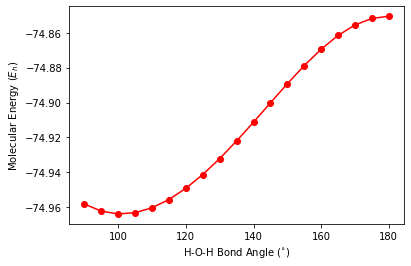

In [35]:
# Visualize energy profile
x = list(scan.keys())
y = list(scan.values())
plt.plot(x,y,'ro-')
plt.xlabel('H-O-H Bond Angle ($^{\circ}$)')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

Using the energy profile we generated above, justify the experimentally measured water bond angle of 104.5$^{\circ}$ in the cell below.

#### Student Answer Box

Cuz bond angle of 104.5 has the lowest electronic energy, yo!